In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [14]:
#Burn phase
def burn(rotation,settings):
    (E,W,B1,B2,B3,B4,B5,B6,inner,J,FF,Tf,AP,NP,H,h,S,I,Mib,Tm,Ts,Tff,Tin,Tw,Tmd,
     fmi,fmd,Dmi,Dmd,fs,fs1,fw,fw1,Dsi,Dsi1,cm,cs,Mi,Mt,Ms,Mm,Mff,mod)=settings
    if rotation=='MFSF':
        def NG(a): return (a-1)*cs*H+cm*H-cs*H*cm*H
        n = (cs*H*(H*cm+1)+2*Tm-H*cm-2*Tmd)/(cs*H-2*Ts)
        Rt = (Tm+Ts*n-0.5*NG(n))
        Trot = Rt*(1+Tff/40.+Tin/(480.-48*B2))
        JoW = (74*0.5+120*0.25*B1)*H*(n+1)/Trot*J
        Mrot = (Mm+Ms*n)/Trot+Mff/40-JoW
        Dm = ((Dmi+fmi*AP)*(1+(1+0.09*B6)*cm)+(Dmd+fmd*AP)*(1+B4/4.))*mod
        Ds = (Dsi+fs*AP)*(1+(1+0.09*B6)*cs)*(1+B3/10.*Tmd/Trot)*mod
        Bdps = (Dm+Ds*n)/Trot
        Tb = Mi/max(1e-6,(Mrot-Mt))
    elif rotation=='SF':
        Ds = (Dsi+fs*AP)*(1+(1+0.09*B6)*cs)*mod
        Rt = Ts-0.5*H*cs
        Trot = Rt*(1+Tff/40.+Tin/(480.-48*B2))
        JoW = (74*0.5+120*0.25*B1)*H/Trot*J
        Mrot = Ms/Trot+Mff/40-JoW
        Bdps = Ds/Trot
        Tb = Mi/max(1e-6,(Mrot-Mt))
    elif rotation=='W':
        JoW = (74*0.5+120*0.25*B1)*H/Tw*J
        Mw = 232/Tw-JoW
        Tb = Mi/max(1e-6,(Mw-Mt))
        Dw = (407.5+fw*NP)*(1+(1+0.09*B6)*cs)*mod/(1+E)
        Bdps = Dw/Tw
    return Tb,Bdps

#Regen phase
def regen(rotation,settings):
    (E,W,B1,B2,B3,B4,B5,B6,inner,J,FF,Tf,AP,NP,H,h,S,I,Mib,Tm,Ts,Tff,Tin,Tw,Tmd,
     fmi,fmd,Dmi,Dmd,fs,fs1,fw,fw1,Dsi,Dsi1,cm,cs,Mi,Mt,Ms,Mm,Mff,mod)=settings
    if rotation=='SF':
        Rt = Ts-0.5*H*cs
        Trot = Rt*(1+Tff/40.+Tin/(480.-48*B2))
        JoW = (74*0.5+120*0.25*B1)*H/Trot*J
        Ms1 = 87/Trot+Mff/40-JoW
        Ds1 = (Dsi1+fs1*AP)*(1+(1+0.09*B6)*cs)*mod
        Rdps = Ds1/(Ts-0.5*H*cs+Tff/40+Tin/(480.-48*B2))
        Tr = Mi/max(1e-6,(Mt-Ms1))
    elif rotation=='NA':
        Mr = 0.7*(0.001+S*np.sqrt(I)*0.009327)*(40-5*FF)/40.
        Rdps = 0
        Tr = Mi/max(1e-6,(Mt+Mr))
    elif rotation=='W':
        JoW = (74*0.5+120*0.25*B1)*H/Tw*J
        Mw1 = 18/Tw-JoW
        Tr = Mi/max(1e-6,(Mt-Mw1))
        Dw1 = (14.5+fw1*NP)*(1+(1+0.09*B6)*cs)*mod/(1+E)
        Rdps = Dw1/Tw
    return Tr,Rdps

#Fight segmentation
def fight(burn_rot,regen_rot,settings,details=False,print_out=False):
    Tf = settings[11]
    Tb,Bdps = burn(burn_rot,settings)
    Tr,Rdps = regen(regen_rot,settings)
    Tb = min(Tb,Tf)
    nr = max(0,math.floor((Tf-Tb)/(Tb+Tr))); nb=nr+1
    Te = max(0,Tf-Tb*nb-Tr*nr)
    Db = Bdps*Tb; Dr = Rdps*Tr; De=(Db+Dr)*Te/(Tb+Tr)
    D = Db*nb+Dr*nr+De; Dps = D/Tf
    if details and print_out: print "DPS={}, Tb={}, Bdps={}, Tr={}, Rdps={}, Te={}, Edps={}".format(Dps,Tb,Bdps,Tr,Rdps,Te,De/Te)
    elif print_out: print "DPS={}".format(Dps)
    else: return Dps

In [34]:
def getStatWeights(rotation,fight_data=(10,600)):
    min_length = fight_data[0]
    max_length = fight_data[1]
    burn_rot = rotation[0]
    regen_rot = rotation[1]
    DPSweights = np.zeros((9,max_length-min_length+1))
    SPweights = np.zeros((8,max_length-min_length+1))
    for Tf in range(min_length,max_length+1):
        variations = [0,0,0,0,0,0,0,0,0]
        default=fight(burn_rot,regen_rot,Settings(Tf))
        for v in range(0,9):
            variations[v]=1
            settingsP=Settings(Tf,variations)
            increase=fight(burn_rot,regen_rot,settingsP)-default
            variations[v]=-1
            settingsN=Settings(Tf,variations)
            decrease=default-fight(burn_rot,regen_rot,settingsN)
            DPSweights[v,Tf-min_length]=(increase+decrease)/2.
            if v==0:
                normal=(increase+decrease)/2.
            else:
                SPweights[v-1,Tf-min_length]=(increase+decrease)/2./normal
            variations[v]=0
    return SPweights,DPSweights

In [45]:
def Settings(Tf,variation=(0,0,0,0,0,0,0,0,0)):
    #adjustable settings
    malE=True #malediction
    E=True #elements
    W=True #misery
    B1=False #T4 2pc, 120 mana proc
    B2=False #T4 4pc, innervate CD -48s
    B3=False #T5 4pc, 10% SF if MF
    B4=False #T6 2pc, extra MF tick
    B5=False #T6 4pc, 5% SF crit
    B6=False #Chaotic Skyfire
    vamp=False #vampiric touch
    spriest_dps=750
    L=False #Bloodlust/Heroism, doesnt do anything
    PI=False #Use Power Infusion, doesnt do anything
    inner=True #Use innervate
    tide=False #Mana tide totem
    spring=True #Mana spring totem
    J=True #Judgement of Wisdom
    FF=True #Use FF in rotation
    Tf=Tf #Fight length
    AP=857+36+80+33+85 #Arcane Spellpower
    NP=857+36+80+33+85 #Nature Spellpower
    c=223/2208.+.05+.01 #Crit chance
    H=0.1197 #Hit chance
    h=0 #haste rating
    S=(137)*1.1 #Gear+Buff Spirit
    I=(287+40)*1.1 #Gear+Buff Intellect
    Mib=2090 #Base mana
    Mp5=50 #Gear+Buff Mp5
    Spellfire=True #spellfire set bonus
    IDS=False #Improved Divine Spirit
    
    #stat weight variation
    AP+=variation[1]+variation[0]
    NP+=variation[2]+variation[0]
    I+=variation[3]; S+=variation[4]
    Mp5+=variation[5]; c+=variation[6]/2208.
    H+=variation[7]/1262.5; h+=variation[8]
    
    
    #calculations
    E=(0.1+0.03*malE)*E #elements
    W=W*0.05 #misery
    c+=I/80./100 #crit from int
    H=min(0.99,0.83+H+0.04) #miss chance
    h=(h/1577.) #haste %
    Tm=max(1.,1.5/(1+h)) #Moonfire cast time
    Ts=max(1.,3./(1+h)) #Starfire cast time
    Tff=max(1.,1.5/(1+h))*FF #FF cast time
    Tin=max(1.,1.5/(1+h))*inner #inervate cast time
    Tw=max(1.,1.5/(1+h)) #wrath cast time
    Tmd=15.+3*B4 #MF duration
    fmi=0.15 #MF instant coeff
    fmd=0.56 #MF DoT coeff
    Dmi=(305+357)/2. #MF initial damage
    Dmd=600. #MF DoT damage
    fs=1+0.2 #SF coeff
    fw=2/3.5+0.1 #wrath coeff
    fs1=fs*(25+11)/70. #rank 1 SF coeff
    fw1=fw*(1+11)/70. #rank 1 wrath coeff
    Dsi=(550+647)/2. #SF damage
    Dsi1=(95+115)/2. #rank 1 SF damage
    cm=min(1,c+0.1) #MF crit
    cs=min(1,c+0.04+0.05*B5) #SF crit
    Mi=Mib+15*I #Initial mana pool
    if Tf>20: nInner=((Tf-20)/(480.-48*B2)+0.5)*inner #number of innervates per fight
    else: nInner=0
    if Tf>12: nTide=((Tf-12)/300.+0.5)*tide #number of mana tides per fight
    else: nTide=0
    mpot=2400. #potion mana
    mrune=1000. #dark rune mana
    Mt=(Mp5/5.+0.3*(0.001+S*np.sqrt(I)*0.009327)+0.1*I/5.+(mpot+mrune)/120.+0.24*nTide*Mi/Tf+
        4.7*(0.001+S*np.sqrt(I)*0.009327)*nInner*20/Tf+spring*20*1.25/2+spriest_dps*0.05*vamp) #constant mana regen
    Ms=int(370*.91) #SF mana cost
    Mm=int(495*.91) #MF mana cost
    Mff=145.*FF #FF mana cost
    AP+=(Spellfire*0.07+0.25)*I+0.1*S*IDS #arcane
    NP+=(Spellfire*0.07+0.25)*I+0.1*S*IDS #nature
    mod=(1+E)*(1+W)*1.1*0.94*H #final damage modifier
    return (E,W,B1,B2,B3,B4,B5,B6,inner,J,FF,Tf,AP,NP,H,h,S,I,Mib,Tm,Ts,Tff,Tin,Tw,
            Tmd,fmi,fmd,Dmi,Dmd,fs,fs1,fw,fw1,Dsi,Dsi1,cm,cs,Mi,Mt,Ms,Mm,Mff,mod)

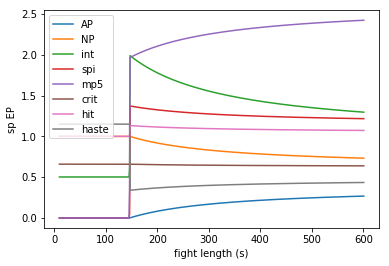

[0.         1.         0.50188992 0.         0.         0.65902145
 1.00028303 1.14966322]
[0.21989521 0.78010479 1.4203952  1.24451374 2.3415569  0.64204645
 1.08307962 0.41727709]


In [44]:
SPweights,DPSweights=getStatWeights(('W','SF'))
stat=['AP','NP','int','spi','mp5','crit','hit','haste']
for n in range(0,8):
    plt.plot(np.linspace(10,601,591),SPweights[n,:],label=stat[n])
plt.xlabel('fight length (s)')
plt.ylabel('sp EP')
plt.legend()
plt.show()
print SPweights[:,90]
print SPweights[:,400]

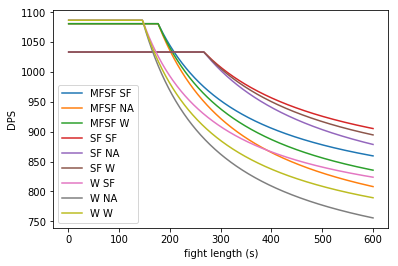

In [36]:
lengths=np.linspace(1,600,600)
for burn_rot in ['MFSF','SF','W']:
    for regen_rot in ['SF','NA','W']:
        dpss=[]
        for fight_length in lengths:
            dpss.append(fight(burn_rot,regen_rot,Settings(fight_length)))
        plt.plot(lengths,dpss,label=burn_rot+' '+regen_rot)
plt.xlabel('fight length (s)')
plt.ylabel('DPS')
plt.legend()
plt.show()

In [39]:
for burn_rot in ['MFSF','SF','W']:
    for regen_rot in ['SF','NA','W']:
        print burn_rot,regen_rot
        fight(burn_rot,regen_rot,Settings(7*60+18),details=True,print_out=True)

MFSF SF
DPS=893.782140177, Tb=162.199673942, Bdps=1080.71060497, Tr=140.119012961, Rdps=440.205349334, Te=275.800326058, Edps=783.848491897
MFSF NA
DPS=850.377072526, Tb=162.199673942, Bdps=1080.71060497, Tr=82.9910115029, Rdps=0, Te=30.6096406138, Edps=714.916667548
MFSF W
DPS=873.595243045, Tb=162.199673942, Bdps=1080.71060497, Tr=86.7576690654, Rdps=136.84814698, Te=26.8429830513, Edps=751.789570612
SF SF
DPS=943.284050311, Tb=251.951532294, Bdps=1033.32184335, Tr=140.119012961, Rdps=440.205349334, Te=186.048467706, Edps=821.352597717
SF NA
DPS=924.567066768, Tb=251.951532294, Bdps=1033.32184335, Tr=82.9910115029, Rdps=0, Te=186.048467706, Edps=777.288602497
SF W
DPS=935.784613113, Tb=251.951532294, Bdps=1033.32184335, Tr=86.7576690654, Rdps=136.84814698, Te=186.048467706, Edps=803.69723332
W SF
DPS=855.215175939, Tb=132.754325976, Bdps=1086.49568397, Tr=140.119012961, Rdps=440.205349334, Te=32.3723350876, Edps=754.629023314
W NA
DPS=795.227497518, Tb=132.754325976, Bdps=1086.495683

In [334]:
def NG_test():
    c=.5
    h=.95
    N=100000
    cs=min(1,c+0.04)
    cm=min(1,c+0.1)
    record={}
    record1={}
    theory1={}
    theory={}
    for n in range(4,18):
        theory1[n]=(n-1)*cs*h+cm*h-cs*h*cm*h
        theory[n]=n*cs*h+cm*h
        NG=0
        for iters in range(N):
            for cast in range(n):
                if cast!=1 and random.random()<cs*h:
                    currentNG=True
                elif cast==1 and random.random()<cm*h:
                    currentNG=True
                if cast!=1:
                    NG+=currentNG
                    currentNG=False
        record[n]=(NG/float(N)-theory[n])/theory[n]
        record1[n]=(NG/float(N)-theory1[n])/theory1[n]
    print record,record1

43.0